<a href="https://colab.research.google.com/github/lasupernova/Tensorflow_apps/blob/master/Food_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ensure GPU compute capability is > 7.0 in order to use mixed precision training acceleration
# here: Tesla T4 needed
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-654e1b1d-68c5-5ff4-8473-65f302edd569)


In [2]:
#download helper functions script from Github
!wget https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py

--2021-09-26 18:15:42--  https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10252 (10K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-26 18:15:42 (36.2 MB/s) - ‘helpers.py’ saved [10252/10252]



In [3]:
import tensorflow as tf

In [4]:
#import helper functions from script
from helpers import create_tensorboard_callback, plot_loss_curves#, compare_histories

##Load Data

In [5]:
#import tf Datasets to download Food 101 dataset using later on 
import tensorflow_datasets as tfds

In [6]:
#overview of all available datasets
datasets_list = tfds.list_builders()

In [7]:
datasets_list;

In [8]:
#load food101 data from tf Datasets
(train_data, test_data), food_info = tfds.load(name="food101",
                                               split=["train", "validation"],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteVZJ9MP/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteVZJ9MP/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


##Explore Data

In [9]:
#get to know dataset
food_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
#get class names
class_names = food_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [11]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [17]:
import matplotlib.pyplot as plt
def explore_data(num_images=9):
  for i in range(num_images):
    train_sample_explore = train_data.take(1)
    # train_sample_explore
    #each sample comes with data (here: image) and a label
    for img, label in train_sample_explore:
      # print(label)  #label is a tensor containing the image class number --> convert to number/np-array (using numpy) in order to translate to class_name
      shape = img.shape
      datatype= img.dtype.name
      img_label = class_names[label.numpy()]
      #Get min and max values in image tensor
      min_val = tf.reduce_min(img); max_val=tf.reduce_max(img)
      normalized = (min_val.numpy()==0 and max_val.numpy()==1)
      normalized_str = "True (min:0, max:1)" if normalized else f'False (value range: {min_val.numpy()} - {max_val.numpy()})'
      info_str = f"""Image has the following features:
          Shape:       {shape}
          dtype:       {datatype}
          Class Name:  {img_label}
          Dataset target class tensor form: {label}
          Normalized:  {normalized_str}"""
    #Plot selected image
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(img_label)
    plt.text(x=shape[1]*1.05,y=shape[0]/2,s=info_str)
    ax=plt.gca()
    ax.set_axis_off()  #or use plt.axis(False)
    plt.show()

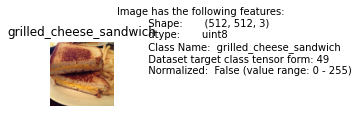

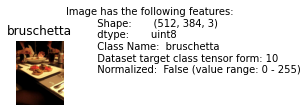

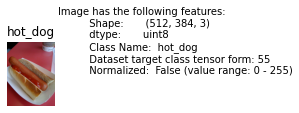

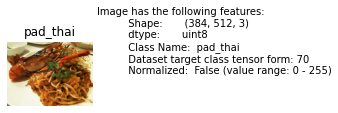

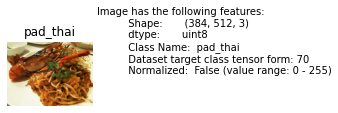

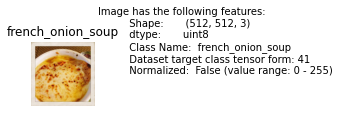

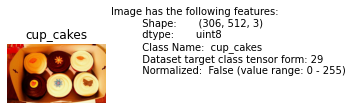

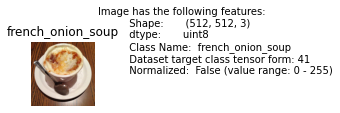

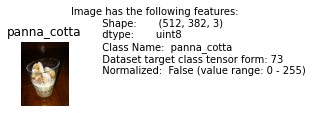

In [18]:
explore_data()

NOTE: image tensor is not yet normalized (as min - max values are not 0 and 1)

NOTE: dataset labels are *NOT* one-hot encoded as the target class tensor contains **one** individual number as opposed to aan array/ a list of the form [0,0,0,1....,0,0]. <br><br>
Additionally, running the cell above for multiple images has shown, that images are *not* of same shape (for height and width).

##Pre-process Images

In [74]:
#pre-processing function (instead of using tf.keras.preprocessing.image_dataset_from_directory)
def preprocess_image(img, label, img_size=224, scale=False):
  """
  Takes image and preprocesses it to standard image, inluding:
    datatype (float32),
    shape([img_size, img_size, color_channel])
    normalization (shouldvalues be scaled to values between 0 - 1)

  Params:
    img - tensor containing image to be preprocessed
    label - number representing class of image
    img_size - number to use for image width and height
    scale - bool to determine if tensor should be normalized (default : True)

  Returns:
    mod_img - modified, preprocessed image
  """
  mod_img = tf.image.resize(img, [img_size, img_size]) #resize height + width
  if scale:
    mod_img = mod_img/255. #normalize
  return tf.cast(mod_img, tf.float32), label  #return float32 -version of modified tensor (could have been, e.g.  uint8 before, but NNs need float32)

In [59]:
test_img = train_data.take(1)

In [60]:
test_img

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [69]:
for img, label in test_img:
  mod, t_label = preprocess_image(img, class_names[label.numpy()], 224, scale=False)

In [70]:
mod, t_label

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[147.30612 , 102.30612 ,  35.30612 ],
         [147.27551 , 102.27551 ,  35.27551 ],
         [148.61224 , 103.61224 ,  36.612244],
         ...,
         [145.61224 , 110.61225 ,  52.612247],
         [145.35715 , 110.35714 ,  52.357143],
         [145.35715 , 110.35714 ,  52.357143]],
 
        [[142.34694 ,  97.34694 ,  30.34694 ],
         [144.85715 ,  99.85714 ,  32.42857 ],
         [146.      , 101.      ,  33.      ],
         ...,
         [144.14285 , 109.14285 ,  53.142857],
         [144.14285 , 109.14285 ,  53.142857],
         [143.2857  , 108.285706,  52.28571 ]],
 
        [[147.54082 , 102.54082 ,  34.540817],
         [147.60204 , 102.60204 ,  34.60204 ],
         [148.08163 , 103.081635,  35.08163 ],
         ...,
         [141.78572 , 106.57144 ,  53.000008],
         [141.07143 , 105.85715 ,  52.285713],
         [141.07143 , 105.85715 ,  52.285713]],
 
        ...,
 
        [[111.367355,  67.367355

## Batch and Prepare Datasets

In [75]:
#map custom preprocessing function to train dataset
"""NOTE: each entry in the dataset consists of 2 parts (a tensor and a label) 
--> the undefined params from the passed function, must also be 2, so that this function will know which input to map to which params
--> more params can be used in fucntion, however these need to have default values (which will then be used during the mapping call)
"""
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

#map custom preprocessing function to test dataset
tesst_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [77]:
#shuffle training data and group into batches
train_data = train_data.shuffle(buffer_size=5000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#shuffle testinging data and group into batches
test_data = test_data.shuffle(buffer_size=5000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [78]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>